# Multiple KRR

In [1]:
import math
import numpy as np
import wandb
from tqdm import tqdm
from torchvision import transforms
from utils import get_data, accuracy, save_Yte, get_sweep_id, augment_dataset
from kernels import GaussianKernel, LinearKernel

Xtr, Xte, Ytr = get_data()

## Model definition

In [2]:
class KRR:
    
    def __init__(self, kernel, class_id, lambd, verbose):
        self.kernel = kernel        
        self.lambd = lambd        
        self.class_id = class_id        
        self.alpha = None
        self.verbose = verbose
       
    def fit(self, y, K):
        if self.verbose: print("Fitting...")
        n = len(y)
        # self.X = X
        self.y = (y == self.class_id)
        self.alpha = np.linalg.inv(K + self.lambd * n * np.eye(n)) @ self.y

    def predict(self, K):
        if self.verbose: print("Predicting...")
        pred = K @ self.alpha
        return pred

class MultiKRR:

    def __init__(self, kernel, lambd=1e-3, verbose=False):
        self.kernel = kernel        
        self.lambd = lambd        
        self.verbose = verbose
        self.KRR_list = [KRR(self.kernel, class_id, self.lambd, self.verbose) for class_id in range(10)]
    
    def fit(self, X, y):
        self.X = X
        K = self.kernel(X,X)
        for krr in tqdm(self.KRR_list, desc="Fitting"):
            krr.fit(y, K)
    
    def predict(self, x):
        K = self.kernel(x,self.X)
        pred = np.array([krr.predict(K) for krr in self.KRR_list]).T
        pred = np.argmax(pred, axis=1)
        return pred

## Testing linear and gaussian kernels

In [18]:
from tqdm import tqdm
accuracy_list_lin = []
accuracy_list_gau = []
lambd_list = [10, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
for lambd in lambd_list:
    krr = MultiKRR(kernel=LinearKernel().kernel, lambd=lambd)
    krr.fit(Xtr, Ytr)
    pred = krr.predict(Xtr)
    accuracy_list_lin.append(accuracy(Ytr, pred))
    krr = MultiKRR(kernel=GaussianKernel().kernel, lambd=lambd)
    krr.fit(Xtr, Ytr)
    pred = krr.predict(Xtr)
    accuracy_list_gau.append(accuracy(Ytr, pred))

Fitting: 100%|██████████| 10/10 [01:03<00:00,  6.38s/it]


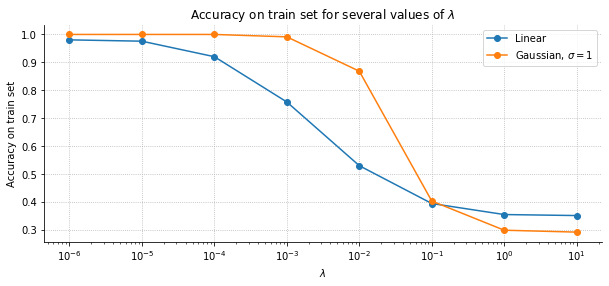

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(np.array(lambd_list)[::-1], np.array(accuracy_list_lin)[::-1], '-o', label="Linear")
plt.plot(np.array(lambd_list)[::-1], np.array(accuracy_list_gau)[::-1], '-o', label="Gaussian, $\sigma=1$")
plt.semilogx()
plt.xlabel("$\lambda$")
plt.ylabel("Accuracy on train set")
plt.title("Accuracy on train set for several values of $\lambda$")
plt.grid(ls=':')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend()
plt.show()

## Making submissions

In [29]:
krr = MultiKRR(kernel=GaussianKernel(sigma=1).kernel, lambd=.001)
krr.fit(Xtr, Ytr)
Yte = krr.predict(Xte)
save_Yte(Yte, model_name="MultiKRR_1")

Fitting: 100%|██████████| 10/10 [00:46<00:00,  4.68s/it]


In [ ]:
krr = MultiKRR(kernel=GaussianKernel(sigma=.5).kernel, lambd=.1)
krr.fit(Xtr, Ytr)
Yte = krr.predict(Xte)
save_Yte(Yte, model_name="MultiKRR_2")

## Adding Kernel PCA

In [37]:
from scipy.linalg import eigh
import matplotlib.pyplot as plt
def kernel_pca(K, n_components):
    """Slide 219/1013"""
    # 1. center Gram matrix
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n @ K - K @ one_n + one_n @ K @ one_n    
    # 2. compute the first eigenvectors (u_i, \Delta_i)
    Delta, u = eigh(K)  # ascending order
    plt.figure(figsize=(20,6))
    plt.plot(range(len(Delta)), Delta)
    plt.show()
    Delta, u = Delta[::-1], u[:,::-1]  # descending order
    Delta, u = Delta[:n_components], u[:,:n_components]  # first eigs
    # 3. normalize the eigenvectors \alpha_i = u_i / \sqrt{\Delta_i}
    alpha = u / Delta
    # 4. return projections K @ alpha
    Xtr_proj = K @ alpha
    return Xtr_proj


In [47]:
krr = MultiKRR(kernel=GaussianKernel(sigma=1).kernel, lambd=.001)
krr.fit(Xtr, Ytr)
print(f"accuracy on training set: {accuracy(Ytr, krr.predict(Xtr))}")
Yte = krr.predict(Xte)
save_Yte(Yte, model_name="KPCA_MultiKRR_1")

Fitting: 100%|██████████| 10/10 [01:21<00:00,  8.20s/it]


accuracy on training set: 0.4444


In [48]:
krr = MultiKRR(kernel=LinearKernel().kernel, lambd=.001)
krr.fit(Xtr, Ytr)
print(f"accuracy on training set: {accuracy(Ytr, krr.predict(Xtr))}")
Yte = krr.predict(Xte)
save_Yte(Yte, model_name="KPCA_MultiKRR_2")

Fitting: 100%|██████████| 10/10 [01:35<00:00,  9.55s/it]


accuracy on training set: 0.2702


## Adding train/val split

In [3]:
from sklearn.model_selection import train_test_split 
Xtr_, Xval_, Ytr_, Yval_ = train_test_split(Xtr, Ytr, test_size=0.1, random_state=123)

In [4]:
Xtr_.shape
Xtr_.shape

(4500, 3072)

In [5]:
def one_run():
    """Perform one run. Will be used with get_sweep_id."""
    wandb.init(
        project='kernel-challenge',  # nom du projet
        entity='theodumont',         # mon compte
        tags=["KRR"],                # nom du modèle
    )
    # on récupère les paramètres
    sigma = wandb.config.sigma
    lambd = wandb.config.lambd
    # on crée le modèle
    krr = MultiKRR(kernel=GaussianKernel(sigma=sigma).kernel, lambd=lambd)
    # on le fit
    krr.fit(Xtr_, Ytr_)
    # on évalue son accuracy et on la store dans le run sur wandb
    wandb.run.summary["accuracy"] = accuracy(Yval_, krr.predict(Xval_))
    
# spécifier le nom range des hyperparamètres, avec 'uniform' ou 'log_uniform
parameters = {
    'sigma': {
        'distribution': 'log_uniform',
        'min': math.log(1e-4),
        'max': math.log(1e2),
    },
    'lambd': {
        'distribution': 'log_uniform',
        'min': math.log(1e-4),
        'max': math.log(1e2),
    },
}

sweep_id = get_sweep_id(parameters)
%env WANDB_SILENT=False

wandb.agent(sweep_id, function=one_run)

## Adding data augmentation

In [4]:
# only add it on the train split
Xtr_augm_, Ytr_augm_ = augment_dataset(Xtr_, Ytr_, transform=[transforms.RandomHorizontalFlip(p=1)])

In [5]:
print(Xtr_.shape)
print(Xval_.shape)
print(Xtr_augm_.shape)
print(Ytr_.shape)
print(Yval_.shape)
print(Ytr_augm_.shape)

(4500, 3072)
(500, 3072)
(9000, 3072)
(4500,)
(500,)
(9000,)


In [6]:
import math
def one_run_2():
    wandb.init(project='kernel-challenge', entity='theodumont', tags=["KRR+augm_"])
    krr = MultiKRR(kernel=GaussianKernel(sigma=wandb.config.sigma).kernel, lambd=wandb.config.lambd)
    krr.fit(Xtr_augm_, Ytr_augm_)
    wandb.run.summary["accuracy"] = accuracy(Yval_, krr.predict(Xval_))

parameters = {
    'sigma': {
        'distribution': 'log_uniform',
        'min': math.log(1e-1),
        'max': math.log(1e1),
    },
    'lambd': {
        'distribution': 'log_uniform',
        'min': math.log(1e-4),
        'max': math.log(1e-2),
    },
    'data_augm': {
        'value': True
    }
}
sweep_id = get_sweep_id(parameters)
%env WANDB_SILENT=True
%env WANDB_NOTEBOOK_NAME="test"

wandb.agent(sweep_id, function=one_run_2)